### 项目介绍
对垃圾邮件进行预测分类     

### 数据预处理
读取特征数据    
将一个文件存为一条数据
先只读取文本内容

首先取出所有文本     
思路为：      
匹配第一个字符为 字母的最后一个元素    
后面的所有元素    
然后拼成一个字符串   

In [8]:
import re
import os
from pandas import DataFrame

In [3]:
# 根据路径打开文件 并提取每个邮件中的文本
def getMailTest(mailPath):
    mail = open(mailPath, "r", encoding="gb2312", errors='ignore')
    mailTextList = [text for text in mail]
    # 去除邮件头
    XindexList = [mailTextList.index(i) for i in mailTextList if re.match("[a-zA-Z0-9]", i)]
    textBegin = max(XindexList) + 1
    text = ''.join(mailTextList[textBegin:])
    # 去空格分隔符及一些特殊字符
    text = re.sub('\s+','',re.sub("\u3000","", re.sub("\n", "",text)))
    return text

In [2]:
# 通过index文件获取所有文件路径及标签值
def getPaths_Labels():
    targets = open("./trec06c/full/index", "r", encoding="gb2312", errors='ignore')
    targetList = [t for t in targets]
    newTargetList = [target.split() for target in targetList if len(target.split()) == 2]  # 分割了标记和路径
    pathList = [path[1].replace('..', './trec06c') for path in newTargetList]
    labeslList = [label[0] for label in newTargetList]
    return pathList, labeslList

In [4]:
# 获取所有文本
def getAllText(pathList):
    textList = [getMailTest(filePath) for filePath in pathList]
    return textList

### 所有文本列表
将所有文本 与目标值拼接成一个DataFrame 并对y值进行01编码

In [5]:
pathList, labeslList = getPaths_Labels()

In [6]:
textList = getAllText(pathList)

In [9]:
# 0 为垃圾邮件 1 为正常邮件
data_df = DataFrame(textList)
data_df['y'] = labeslList
data_df['y'] = data_df['y'].apply(lambda x:0 if x == "spam" else 1 )

In [10]:
data_df.head()

,0,y
0,非财务纠淼牟莆窆芾-（沙盘模拟）------如何运用财务岳硖岣吖芾砑ㄐ[课程背景]每一位管理...,0
1,讲的是孔子后人的故事。一个老领导回到家乡，跟儿子感情不和，跟贪财的孙子孔为本和睦。老领导的弟...,1
2,尊敬的贵公司(财务/经理)负责人您好！我是深圳金海实业有限公司（广州。东莞）等省市有分公司。...,0
3,贵公司负责人(经理/财务）您好：深圳市华龙公司受多家公司委托向外低点代开部分增值税电脑发票（...,0
4,其实cashfiesta的赚钱途径还有很多，比如游戏赚点，注册赚点等很多方法哦！当你注册以后...,0


### 观察数据特点 基本不存在数据不平衡问题

In [11]:
data_df['y'].value_counts()

0    42854
1    21766
Name: y, dtype: int64

### 训练模型
用tfidf方法训练
第一步 分词

In [12]:
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import pandas as pd
import time

### 加载停用词 分词

In [13]:
with open('./stopwords.txt', encoding='utf8') as file:
    file_str = file.read()
    stopword_list = file_str.split('\n')
    stopword_set = set(stopword_list)

In [14]:
cutWords_list = []
i = 0
startTime = time.time()
for mail in textList:
    cutWords = [k for k in jieba.lcut(mail) if k not in stopword_list]
    i += 1 
    cutWords_list.append(cutWords)
print('共%d篇邮件，分词共花费%.2f秒' %(i, time.time()-startTime))

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.022 seconds.
Prefix dict has been built succesfully.


共64620篇邮件，分词共花费386.87秒


### 保存分词模型

In [15]:
with open('cutWords_list.txt', 'w',encoding="gb2312") as file: 
    for cutWords in cutWords_list:
        file.write(' '.join(cutWords) + '\n')

### tfidf向量  训练模型  预测模型

In [16]:
tfidf = TfidfVectorizer(cutWords_list, stop_words=stopword_set, min_df=40, max_df=0.3)

In [17]:
X = tfidf.fit_transform(data_df[0])
y = data_df['y']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,data_df['y'],test_size=0.3, random_state=666)

### 建立逻辑回归模型

In [27]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_model.score(X_test, y_test)

0.9319096255029403

### 模型评估 混淆矩阵

In [129]:
# 长得不好看 换一个直观一点的
import matplotlib.pyplot as plt 
%matplotlib inline
def show_confusion_matrix(cnf_matrix, class_labels):
    plt.matshow(cnf_matrix, cmap=plt.cm.YlGn, alpha=0.7)
    ax = plt.gca()
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks(range(0, len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_ylabel('Actual Label',fontsize=16, rotation=90)
    ax.set_yticks(range(0,len(class_labels)))
    ax.set_yticklabels(class_labels)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    
    for row in range(len(cnf_matrix)):
        for col in range(len(cnf_matrix[row])):
            ax.text(col, row, cnf_matrix[row][col], va='center', ha='center',fontsize=16)

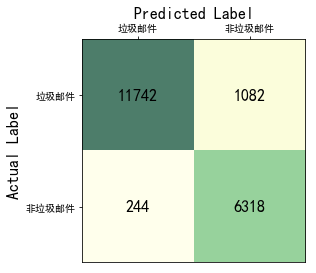

In [130]:
from sklearn.metrics import confusion_matrix
plt.rcParams['font.sans-serif'] = ['SimHei'] # 正常显示中文
pred_y = logistic_model.predict(X_test)
class_labels = ['垃圾邮件','非垃圾邮件']
cnf_matrix = confusion_matrix(y_test, pred_y)
show_confusion_matrix(cnf_matrix, class_labels)
plt.show()

In [113]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def eval_model(y_true, y_pred, labels):
    # 计算每个分类的Precision, Recall, f1, support
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred)
    # 计算总体的平均Precision, Recall, f1, support
    tot_p = np.average(p, weights=s)
    tot_r = np.average(r, weights=s)
    tot_f1 = np.average(f1, weights=s)
    tot_s = np.sum(s)
    res1 = pd.DataFrame({
        u'Label': labels,
        u'Precision': p,
        u'Recall': r,
        u'F1': f1,
        u'Support': s
    })
    res2 = pd.DataFrame({
        u'Label': ['总体'],
        u'Precision': [tot_p],
        u'Recall': [tot_r],
        u'F1': [tot_f1],
        u'Support': [tot_s]
    })
    res2.index = ['/']
    res = pd.concat([res1, res2])
    return res[['Label', 'Precision', 'Recall', 'F1', 'Support']]

eval_model(y, predict_y_decoded, labelEncoder.classes_)

,Label,Precision,Recall,F1,Support
0,0,0.985623,0.916671,0.949897,42854
1,1,0.855799,0.973675,0.910939,21766
/,总体,0.941894,0.935871,0.936775,64620


### 利用网格搜索优化模型

网格搜索 GridSearch：      
原理非常简单，就是把“网格”中所有的参数和模型都跑一遍     
然后得出报表，以观察**给定参数和模型**下哪种参数和模型效果更好     
因为它要跑很多模型和参数，所以一一般**不适合太大的数据集**      
工具包直接集成在sklearn中，可直接调用

参数（部分）：      
estimator 指定模型对象，就是去搜索它的参数     
param_grid 参数集，传进来一个字典        
scoring=None评估方法，不指定为默认（score()， accuracy())     
cv K折交叉验证      

属性（部分）：     
bast_estimator_  最佳模型，是一个对象，使用它的fit()方法就可以训练出最好的模型      
bast_score_: 最佳准确率     
bast-params_: 最佳参数组合     

In [28]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty':('l1', 'l2'),
    'C':(0.001, 0.01, 0.1, 1, 10)
}
lr_search = GridSearchCV(logistic_model,parameters,scoring='accuracy', cv=5)
lr_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [29]:
lr_search.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
lr_search.best_score_

0.93343502674979